Assignment 4: Multi-Output Networks and Batch Processing
========================================================


Microsoft Forms Document: https://forms.office.com/r/nHKeCdSmTz


Task 1: Dataset Loading
-----------------------

Load the dataset from files and provide the input matrix $\mathbf X \in \mathbb R^{(D+1)\times N}$ and the output matrix $\mathbf T \in \mathbb R^{O\times N}$.
For more information about the dataset, refer to https://archive.ics.uci.edu/ml/datasets/Student+Performance.

We skip categorical inputs (indexes 8-11) for now.
All other entries are converted either into binary $(-1,1)$ or into an integer range $(0,1,\ldots)$.
The three outputs range between 0 and 20 each.

In [1]:
import math
import numpy
np = numpy
import os

# Dataset origin: https://archive.ics.uci.edu/ml/datasets/Student+Performance

def dataset(course="mat"):
  # load dataset and provide input and target data
  # possible data files are "mat" and "por"

  # download data file from URL
  dataset_zip_file = "student.zip"
  if not os.path.exists(dataset_zip_file):
    import urllib.request
    urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip", dataset_zip_file)
    print ("Downloaded datafile", dataset_zip_file)

  import zipfile
  import csv
  import io

  # collect inputs
  inputs = []
  targets = []
  # some default values: yes=1, no=-1
  yn = {"yes":1.,"no":-1.}
  # read through dataset (without actually unzippiung to a file):
  # ... open zip file
  zip = zipfile.ZipFile(dataset_zip_file)
  # ... open data file inside of zip file and convert bytes to text
  datafile = io.TextIOWrapper(zip.open(os.path.join(F"student-{course}.csv"), 'r'))
  # ... read through the lines via CSV reader, using the correct delimited
  reader = csv.reader(datafile, delimiter=";")
  # ... skip header line
  next(reader)
  for splits in reader:
    # read input values
    inputs.append([
      1.,                             #### BIAS ####
      {"GP":1.,"MS":-1.}[splits[0]],  # school
      {"M":1.,"F":-1.}[splits[1]],    # gender
      float(splits[2]),               # age
      {"U":1.,"R":-1.}[splits[3]],    # address
      {"LE3":1.,"GT3":-1.}[splits[4]],# family size
      {"T":1.,"A":-1.}[splits[5]],    # parents living together
      float(splits[6]),               # mother education
      float(splits[7]),               # father education
      # skip categorical values
      float(splits[12]),              # travel time
      float(splits[13]),              # study time
      float(splits[14]),              # failures
      yn[splits[15]],                 # extra support
      yn[splits[16]],                 # family support
      yn[splits[17]],                 # paid support
      yn[splits[18]],                 # activities
      yn[splits[19]],                 # nursery school
      yn[splits[20]],                 # higher education
      yn[splits[21]],                 # internet
      yn[splits[22]],                 # romantic
      float(splits[23]),              # family relation
      float(splits[24]),              # free time
      float(splits[25]),              # going out
      float(splits[26]),              # workday alcohol
      float(splits[27]),              # weekend alcohol
      float(splits[28]),              # health
      float(splits[29]),              # absences
    ])

    # read targets values
    targets.append([
      float(splits[30]),              # grade for primary school
      float(splits[31]),              # grade for secondary school
      float(splits[32]),              # grade for tertiary school
    ])

  print(F"Loaded dataset with {len(targets)} samples")
  return np.transpose(np.array(inputs)), np.transpose(np.array(targets))

Test 1: Assert Valid Outputs
----------------------------

Load the dataset and check that all target data are in range 0-20. Also make sure that the dataset is in the correct dimensions, i.e., $\mathbf X\in \mathbb R^{(D+1)\times N}$ and $\mathbf T \in \mathbb R^{O\times N}$.

In [2]:
# load dataset
# load dataset
X, T = dataset("mat")

# check validity
D=len(X) #27
N=len(X[0]) #395
O=3

assert (np.all(np.array(T)) >= 0) and (np.all(np.array(T)<=20)) 
print("Dataset Range okay.")

assert np.shape(np.array(X))==(D,N)
print("Shape of X is", D ,"x", N)

assert np.shape(np.array(T) )==(O,N)
print("Shape of T is", O, "x",N)

Downloaded datafile student.zip
Loaded dataset with 395 samples
Dataset Range okay.
Shape of X is 27 x 395
Shape of T is 3 x 395


Task 2: Input Data Normalization
--------------------------------

Implement a function that normalizes all input data using the whitening method with given mean and standard deviation.
Compute the mean and the standard deviation for your dataset.
Make sure that you handle the bias neuron $x_0$ correctly.
Finally, normalize your input data using the implemented function.

In [3]:
# compute mean and standard deviation over dataset
# compute mean and standard deviation over dataset
mean = np.mean(X, axis=1) #average for each row
std = np.std(X, axis=1)

# assure to handle x_0 correctly
mean[0]=0
std[0]=1 #avoid division by 0

def normalize(x, mean, std):
  # standardize the given data with the given meand and standard deviation
  return ((x.T-mean)/std).T

# normalize our dataset
X = normalize(X, mean, std)

Task 3: Batch Processing
------------------------

Implement a function that turns the dataset $(X,T)$ into batches of a certain batch size $B$.
Implement this function as a generator function, i.e., use ``yield`` instead of ``return``.
Make sure that you yield both the input batch as well as the target batch.


In [4]:
def batch(X, T, batch_size=16):
  shuffle = np.random.permutation(T.shape[1])
  idx = 0
  while True:
    # shuffle dataset in each epoch
    yield X[:,shuffle[idx:idx + batch_size]], T[:,shuffle[idx:idx + batch_size]]
    idx += batch_size
    if (idx >= T.shape[1]):
      shuffle = np.random.permutation(T.shape[1])
      idx = 0

Test 2: Test your Batches
-------------------------

Make sure that your batch function returns batches in the correct size and with the correct content, i.e., $(\vec x, \vec t)$-alignment.
Select appropriate test data that makes it easy to test this.

Also check that the batches are in the correct dimensions, i.e., that $\mathbf X \in \mathbb R^{(D+1)\times B}$ and $\mathbf T \in \mathbb R^{O\times B}$

In [5]:
# designe and create test data to test your batch processing function
# designe and create test data to test your batch processing function
xx = np.arange(0,40,2)
XX=np.array([xx,10*xx]) #2x20
TT = 2*XX

for counter, (x,t) in enumerate(batch(XX, TT, 10)):
  # test that the batches are in the desired form and content
  assert np.all(t==2*x)

  # we run this for a couple of batches, to assure that it works over some epochs
  if counter == 20: break

print("Batches are as expected")

Batches are as expected


Task 4: Multi-Output Network
----------------------------

Implement a multi-target network that computes the output matrix $\mathbf Y$ for a given input dataset/batch $\mathbf X$ and given parameters $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$. 
The function should return both the output of the hidden units $\mathbf H$ as well as the network output $\mathbf Y$. Select $\tanh$ as the activation function.

In [6]:
def network(X, Theta):
  W1, W2 = Theta

  # compute activation
  A = np.matmul(W1, X)

  # compute hidden unit output
  H = (np.exp(A) - np.exp(-A)) / (np.exp(A) + np.exp(-A))
  H[0] = 1

  # compute network output
  Y = np.dot(W2, H)

  return Y, H

Task 5: Loss Implementation
---------------------------

Implement a function that computes the loss $\mathcal J^{L_2}_\Theta$ for a given network output $\mathbf Y$, and their according targets $\mathbf T$.

In [7]:
def loss(Y, T):
  N=len(Y[0])
  return 1/N*np.linalg.norm(Y-T, "fro")**2 #Frobenius norm

Task 6: Gradient Implementation
-------------------------------

Implement a function that computes the gradient $\nabla_\Theta\mathcal J^{L_2}$ for both weight matrices $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$.
Assume that the function gets the network input, $\mathbf X$, its output $\mathbf Y$, hidden unit activations $\mathbf H$ and target values $\mathbf T$.
Remember that we have used $\tanh$ as the activation function and change the implementation seen in the lecture accordingly.


In [8]:
def gradient(X, T, Y, H, Theta):
  W1, W2 = Theta

  # first layer gradient
  g1 = (2/np.shape(Y)[1])*np.dot((np.dot(W2.T,(Y-T))*(1-H**2)),X.T)
  # second layer gradient
  g2 = (2/np.shape(Y)[1])*(np.dot((Y-T),H.T))
 
  return g1, g2

Task 7: Iterative Gradient Descent
----------------------------------
Implement the iterative gradient descent using the normalized dataset from Task 2, split into batches with the function from Task 3, the network from Task 4, the loss from Task 5 and the gradient from Task 6.
Make sure that the network output $\mathbf Y$ and the hidden unit output $\mathbf H$ is computed only once for each batch.
Store the loss values for each batch in a list and return it at the end.
Use the number of epochs to be 10000, the batch size $B$, and the learning rate $\eta=0.001$.
How many iterations do we need when $B<N$?

In [9]:
def gradient_descent(X, T, Theta, B, eta=0.001):
  loss_values = []
  (W1, W2) = Theta
  max_epochs = 10000
  epoch = 0
  data_num = 0
  x_ticks = []
  # iterate over batches
  gen = batch(X, T, batch_size=B)
  for c, (x, t) in enumerate(gen):
    # compute network output
    (y, h) = network(x, (W1, W2))

    # compute gradient
    (g1, g2) = gradient(x, t, y, h, (W1, W2))

    # compute and append loss
    l = loss(y, t)

    # and apply gradient descent
    W1 -= eta * g1 
    W2 -= eta * g2 

    data_num += B
    if data_num > len(T[0]):
      epoch += 1
      data_num = 0
      loss_values.append(l)
      if (epoch >= max_epochs):
        break

  # return the obtained loss values at the end
  return loss_values

Task 8: Run Gradient Descent
----------------------------

Select an appropriate number of hidden neurons $K$.
Instantiate the weight matrices using the Xavier method as introduced in the lecture.
Run the gradient descent twice, once as stochastic gradient descent with batch size $B=16$ and once as normal gradient descent.
How can you achieve this without providing a different implementation for the ``gradient_descent`` function?


In [10]:
K = 20
D = len(X)
O = 3
W1 = np.random.uniform(-1/np.sqrt(D), 1/np.sqrt(D), (K,D)) ######W0=0??
W2 = np.random.uniform(-1/np.sqrt(D), 1/np.sqrt(D), (O,K))
Theta = [W1, W2]

import copy

# run gradient descent with full dataset
Theta1 = copy.deepcopy(Theta)
GD = gradient_descent(X, T, Theta1, len(X[0]), eta=0.001)

# run stochastic gradient descent with batches of size 16
Theta2 = copy.deepcopy(Theta)
SGD = gradient_descent(X, T, Theta2, 16, eta=0.001)

Task 9: Plotting Loss Progression
---------------------------------

Plot the progression of the two gradient descent steps together into one plot.
Do we need to take care of something when plotting both together?
Choose logarithmic axes whenever you see fit.

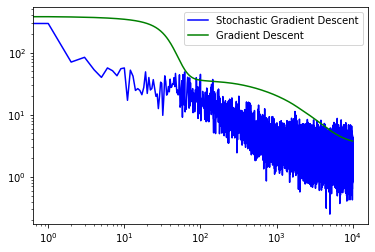

In [11]:
from matplotlib import pyplot

pyplot.plot(SGD, "b-", label="Stochastic Gradient Descent")
pyplot.plot(GD, "g-", label="Gradient Descent")
pyplot.legend()
pyplot.loglog()
pyplot.show()

Task 10: Example Evaluation
---------------------------

We want to see what the network has learned.
Therefore, we evaluate some data point that would represent a typical Swiss student (except for the school entry, where we select one of them randomly).
We select appropriate information for all inputs, see https://archive.ics.uci.edu/ml/datasets/Student+Performance for an explanation of typical values.

Also remember that input data need to be normalized before feeding it to the network.

In [12]:
# select a specific example
example = numpy.array([[
  1., # BIAS
  -1, # school (select -1 or 1)
  1, # gender
  18, # age
  1, # adress
  1, # family size
  1, # parents living together
  1, # mother education
  1, # father education
  1, # travel time
  4, # study time
  0, # class failure before

  1, # support from school
  1, # support from the family
  1, # paid extra support
  -1, # out-of-school activities
  1, # nursery school
  1, # want to do higher ed
  1, # internet access
  1, # romantic relation

  1, # relation to family
  3, # amount of free time
  1, # go out with peers
  6, # alcoholic drinks during week
  1, # alcoholic drinks in the weekend
  1, # health status
  0 # days of absence
]]).T

example = normalize(example, mean, std)

# compute network output
prediction, h = network(example, Theta2)
print("Prediction :\t", prediction.T)


Prediction :	 [[12.95429357 14.18527714  8.67407125]]


Task 11: Influence of Data Dimensions
-------------------------------------

We modify particular dimensions of the input and evaluate how this changes the predicted grades.
Particularly, we test:

* if it makes a difference to be female (-1) or male (1) at index 2
* if the student takes paid classes (-1 or 1) at index 14
* if a romantic relationship influences (-1 or 1) the results at index 19
* how much of daily alcohol consumption (1-6) is still OK at index 23

Note that the indexes include the fact that we are omitting some input dimensions, so they might differ to what is listed on the webpage.


In [13]:
def predict_grade(x,theta, index, value):
  x = x.copy()
  x[index,:]=value
  return network(x,theta)[0]

# run this with the 4 modifications and their according values as seen above
# note that we use normalized data in all cases (for X, example and values)
for index in [2,14,19,23]:
  for value in numpy.unique(X[index,:]):
    print("For index: {}, value {}, the predicted output is {}"
.format(index,value,predict_grade(example,Theta2,index,value).T))

For index: 2, value -0.9481763873554659, the predicted output is [[12.95672823 14.1649579   8.67044622]]
For index: 2, value 1.0546560886092884, the predicted output is [[12.95429357 14.18527714  8.67407125]]
For index: 14, value -0.9196708066060205, the predicted output is [[12.94423069 14.14026909  8.62990333]]
For index: 14, value 1.0873455945507646, the predicted output is [[12.95429357 14.18527714  8.67407125]]
For index: 19, value -0.7084498152194034, the predicted output is [[13.17262112 14.11204308  8.47218149]]
For index: 19, value 1.4115325863841144, the predicted output is [[12.95429357 14.18527714  8.67407125]]
For index: 23, value -0.5406986566036547, the predicted output is [[17.10796171 16.6049923  12.67616791]]
For index: 23, value 0.583385392651312, the predicted output is [[17.88478987 17.83026278 13.49235493]]
For index: 23, value 1.7074694419062786, the predicted output is [[17.28435371 17.77838633 13.21654874]]
For index: 23, value 2.831553491161245, the predicted 